# Inferencia

In [47]:
import requests
from PIL import Image
from io import BytesIO

url = "http://localhost:8000/predict/image?model_type=rtdetr"
file_path = "/Users/juank/Desktop/computer_vision/proyecto/Imagenes/val/video_13min_356.jpg"

with open(file_path, "rb") as f:
    files = {"file": (file_path, f, "image/jpeg")}
    response = requests.post(url, files=files)

image = Image.open(BytesIO(response.content))
image.show()

python(11476) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [48]:
import requests
from PIL import Image
from io import BytesIO

url = "http://localhost:8000/predict/image?model_type=yolo"
file_path = "/Users/juank/Desktop/computer_vision/proyecto/Imagenes/val/video_13min_356.jpg"

with open(file_path, "rb") as f:
    files = {"file": (file_path, f, "image/jpeg")}
    response = requests.post(url, files=files)

image = Image.open(BytesIO(response.content))
image.show()

python(11485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(11486) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [24]:
import requests
from PIL import Image
from io import BytesIO

url = "https://64fe-186-84-20-126.ngrok-free.app/predict/image"
file_path = "/Users/juank/Desktop/computer_vision/proyecto/Imagenes/val/video_13min_356.jpg"

with open(file_path, "rb") as f:
    files = {"file": (file_path, f, "image/jpeg")}
    response = requests.post(url, files=files)

image = Image.open(BytesIO(response.content))
image.show()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x2eb929170>

In [ ]:
import requests
from PIL import Image
from io import BytesIO

url = "http://localhost:8000/predict/image"
file_path = "/Users/juank/Desktop/computer_vision/proyecto/Imagenes/val/video_13min_356.jpg"

with open(file_path, "rb") as f:
    files = {"file": (file_path, f, "image/jpeg")}
    response = requests.post(url, files=files)

image = Image.open(BytesIO(response.content))
image.show()

In [30]:
import requests
from PIL import Image
from io import BytesIO

url = "http://localhost:8000/predict"
file_path = "/Users/juank/Desktop/computer_vision/proyecto/Imagenes/val/video_13min_356.jpg"

with open(file_path, "rb") as f:
    files = {"file": (file_path, f, "image/jpeg")}
    response = requests.post(url, files=files)
response.json()

{'detections': [{'label': 1,
   'score': 0.631527841091156,
   'box': [466.223388671875,
    294.3908996582031,
    649.8968505859375,
    433.1279602050781]},
  {'label': 1,
   'score': 0.591094434261322,
   'box': [556.551025390625,
    104.88703155517578,
    821.3348388671875,
    247.00428771972656]},
  {'label': 1,
   'score': 0.5871527791023254,
   'box': [739.7943115234375,
    218.84217834472656,
    923.9932250976562,
    350.6268310546875]},
  {'label': 1,
   'score': 0.5498034358024597,
   'box': [410.1802978515625,
    188.45123291015625,
    571.0503540039062,
    320.9646301269531]},
  {'label': 1,
   'score': 0.5191236734390259,
   'box': [257.5821533203125,
    76.80142211914062,
    446.2261962890625,
    215.1477508544922]}]}

### RTDETR

Evaluando inferencia en todas las imágenes...


100%|██████████| 372/372 [00:46<00:00,  7.92it/s]



📊 Precision: 0.704
📊 Recall:    0.400


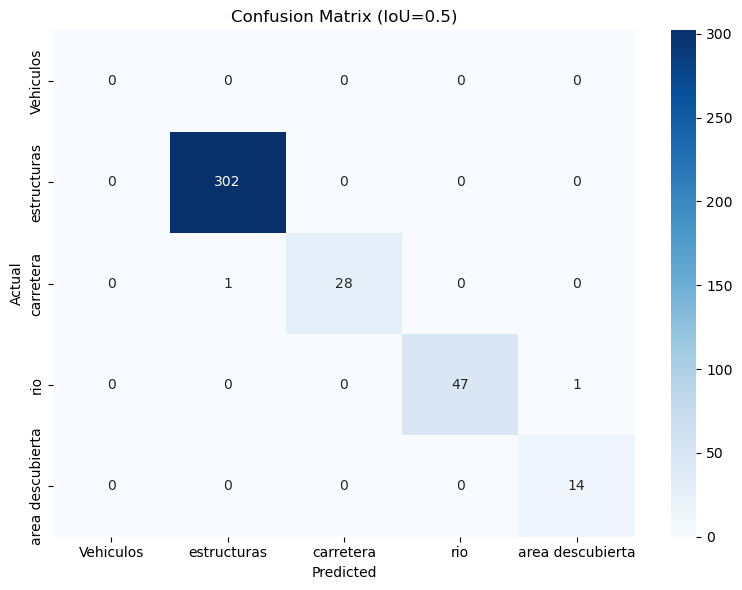

In [49]:
import os
import requests
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from ultralytics.utils.metrics import box_iou
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
IMGS_DIR = "/Users/juank/Desktop/computer_vision/proyecto/Imagenes/test"
LABELS_DIR = "/Users/juank/Desktop/computer_vision/proyecto/Etiquetas/test"
URL = "http://localhost:8000/predict?model_type=rtdetr"
CLASS_NAMES = ['Vehiculos', 'estructuras', 'carretera', 'rio', 'area descubierta']
NUM_CLASSES = len(CLASS_NAMES)
IOU_THRESHOLDS = [0.5, 0.75]  # para mAP@0.5 y @0.5:0.95

# Función para leer etiquetas reales en formato YOLO
def load_yolo_labels(txt_path, img_w, img_h):
    labels = []
    with open(txt_path) as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            xmin = int((x - w / 2) * img_w)
            ymin = int((y - h / 2) * img_h)
            xmax = int((x + w / 2) * img_w)
            ymax = int((y + h / 2) * img_h)
            labels.append([int(cls), xmin, ymin, xmax, ymax])
    return labels

# Almacenar predicciones y etiquetas
all_preds = []
all_gts = []

print("Evaluando inferencia en todas las imágenes...")

for img_name in tqdm(os.listdir(IMGS_DIR)):
    if not img_name.endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(IMGS_DIR, img_name)
    label_path = os.path.join(LABELS_DIR, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    # Tamaño de imagen
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Realizar inferencia vía API
    with open(img_path, "rb") as f:
        files = {"file": (img_path, f, "image/jpeg")}
        response = requests.post(URL, files=files)
        detections = response.json()["detections"]

    # Convertir predicciones
    preds = []
    for d in detections:
        label = int(d["label"])
        score = float(d["score"])
        xmin, ymin, xmax, ymax = map(int, d["box"])
        preds.append([label, score, xmin, ymin, xmax, ymax])

    # Convertir etiquetas reales
    gts = load_yolo_labels(label_path, w, h)

    all_preds.append(preds)
    all_gts.append(gts)

# =============================
# Evaluación (mAP y métricas)
# =============================
def compute_metrics(preds_all, gts_all, iou_thresh=0.5):
    TP, FP, FN = 0, 0, 0
    y_true, y_pred = [], []

    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)

    for preds, gts in zip(preds_all, gts_all):
        matched = set()
        gt_boxes = [gt[1:] for gt in gts]
        gt_classes = [gt[0] for gt in gts]

        for pred in preds:
            pred_cls, score, *box = pred
            box = np.array(box).reshape(1, 4)

            if len(gt_boxes) > 0:
                ious = box_iou(torch.tensor(box), torch.tensor(gt_boxes)).numpy()[0]
                best_iou_idx = np.argmax(ious)
                best_iou = ious[best_iou_idx]

                if best_iou >= iou_thresh and best_iou_idx not in matched:
                    true_cls = gt_classes[best_iou_idx]
                    confusion[true_cls, pred_cls] += 1
                    y_true.append(true_cls)
                    y_pred.append(pred_cls)
                    matched.add(best_iou_idx)
                    TP += 1
                else:
                    FP += 1
            else:
                FP += 1

        FN += len(gt_boxes) - len(matched)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    return precision, recall, confusion

# Calcular métricas
import torch
precision, recall, cm = compute_metrics(all_preds, all_gts, iou_thresh=0.5)

# Mostrar resultados
print(f"\nPrecision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")

# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (IoU=0.5)")
plt.tight_layout()
plt.show()

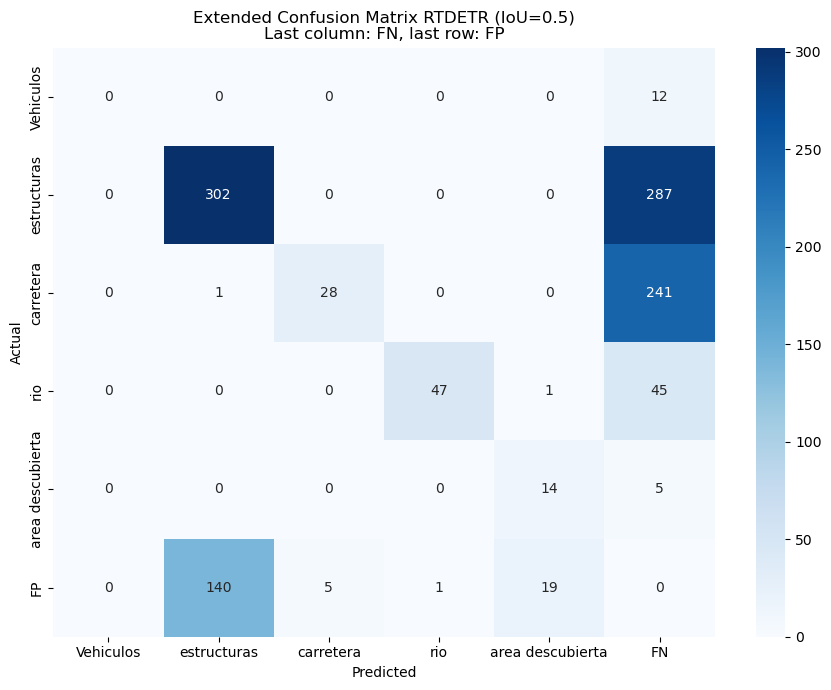

In [50]:
import numpy as np

NUM_CLASSES = len(CLASS_NAMES)
cm = np.zeros((NUM_CLASSES+1, NUM_CLASSES+1), dtype=int)  # +1 para FN y FP

for preds, gts in zip(all_preds, all_gts):
    matched = set()
    gt_boxes = [gt[1:] for gt in gts]
    gt_classes = [gt[0] for gt in gts]

    # Match detections to ground truth
    for pred in preds:
        pred_cls, score, *box = pred
        box = np.array(box).reshape(1, 4)

        if len(gt_boxes) > 0:
            ious = box_iou(torch.tensor(box), torch.tensor(gt_boxes)).numpy()[0]
            best_iou_idx = np.argmax(ious)
            best_iou = ious[best_iou_idx]

            if best_iou >= 0.5 and best_iou_idx not in matched:
                true_cls = gt_classes[best_iou_idx]
                cm[true_cls, pred_cls] += 1  # Acierto
                matched.add(best_iou_idx)
            else:
                cm[NUM_CLASSES, pred_cls] += 1  # FP (detectó algo que no corresponde)
        else:
            cm[NUM_CLASSES, pred_cls] += 1  # FP

    # Falsos negativos: ground truths no detectados
    for i, gt in enumerate(gts):
        if i not in matched:
            true_cls = gt[0]
            cm[true_cls, NUM_CLASSES] += 1  # FN (no detectó objeto real)

# Etiquetas para matriz extendida
xticks = CLASS_NAMES + ['FN']
yticks = CLASS_NAMES + ['FP']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=xticks, yticklabels=yticks, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Extended Confusion Matrix RTDETR (IoU=0.5)\nLast column: FN, last row: FP")
plt.tight_layout()
plt.show()

In [51]:
import numpy as np
import torch
from ultralytics.utils.metrics import box_iou

def compute_ap(recall, precision):
    """Interpolated AP calculation (VOC style)."""
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])

    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap

def compute_map(preds_all, gts_all, num_classes=5):
    """
    preds_all: lista de predicciones por imagen. 
        Cada predicción es [label, score, xmin, ymin, xmax, ymax]
    gts_all: lista de ground truth por imagen.
        Cada gt es [label, xmin, ymin, xmax, ymax]
    num_classes: cantidad de clases
    """
    iou_thresholds = np.arange(0.5, 1.0, 0.05)
    aps = {iou: [] for iou in iou_thresholds}

    for cls in range(num_classes):
        cls_preds_all = []
        cls_gts_all = []

        for img_idx, (preds, gts) in enumerate(zip(preds_all, gts_all)):
            preds_cls = [p for p in preds if p[0] == cls]
            gts_cls = [g for g in gts if g[0] == cls]

            for p in preds_cls:
                cls_preds_all.append({
                    "image_id": img_idx,
                    "bbox": np.array(p[2:]),
                    "score": p[1]
                })
            for g in gts_cls:
                cls_gts_all.append({
                    "image_id": img_idx,
                    "bbox": np.array(g[1:]),
                    "detected": False
                })

        cls_preds_all.sort(key=lambda x: x["score"], reverse=True)

        for iou_thresh in iou_thresholds:
            tp = np.zeros(len(cls_preds_all))
            fp = np.zeros(len(cls_preds_all))
            total_gts = sum([1 for g in cls_gts_all if g['image_id'] is not None])

            for i, pred in enumerate(cls_preds_all):
                gts_for_image = [g for g in cls_gts_all if g["image_id"] == pred["image_id"]]
                pred_box = torch.tensor(pred["bbox"]).unsqueeze(0)
                best_iou = 0
                best_gt = None

                for gt in gts_for_image:
                    gt_box = torch.tensor(gt["bbox"]).unsqueeze(0)
                    iou = box_iou(pred_box, gt_box)[0, 0].item()
                    if iou > best_iou:
                        best_iou = iou
                        best_gt = gt

                if best_iou >= iou_thresh and best_gt and not best_gt["detected"]:
                    tp[i] = 1
                    best_gt["detected"] = True
                else:
                    fp[i] = 1

            if total_gts == 0:
                aps[iou_thresh].append(0)
                continue

            tp_cumsum = np.cumsum(tp)
            fp_cumsum = np.cumsum(fp)
            recall = tp_cumsum / (total_gts + 1e-6)
            precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
            ap = compute_ap(recall, precision)
            aps[iou_thresh].append(ap)

    # mAP@0.5 y mAP@0.5:0.95
    map_05 = np.mean(aps[0.5])
    map_5095 = np.mean([np.mean(aps[t]) for t in iou_thresholds])

    return {
        "mAP@0.5": map_05,
        "mAP@0.5:0.95": map_5095,
        "AP_per_class@0.5": aps[0.5],
        "iou_thresholds": list(iou_thresholds)
    }

In [52]:
resultados = compute_map(all_preds, all_gts, num_classes=5)
resultados

{'mAP@0.5': 0.3377596291290182,
 'mAP@0.5:0.95': 0.033775962912901816,
 'AP_per_class@0.5': [0.0,
  0.42983704738705314,
  0.09661488749197278,
  0.5004480077143441,
  0.6618982030517208],
 'iou_thresholds': [0.5,
  0.55,
  0.6000000000000001,
  0.6500000000000001,
  0.7000000000000002,
  0.7500000000000002,
  0.8000000000000003,
  0.8500000000000003,
  0.9000000000000004,
  0.9500000000000004]}

### YOLO

Evaluando inferencia en todas las imágenes...


100%|██████████| 372/372 [01:33<00:00,  4.00it/s]


📊 Precision: 0.534
📊 Recall:    0.514


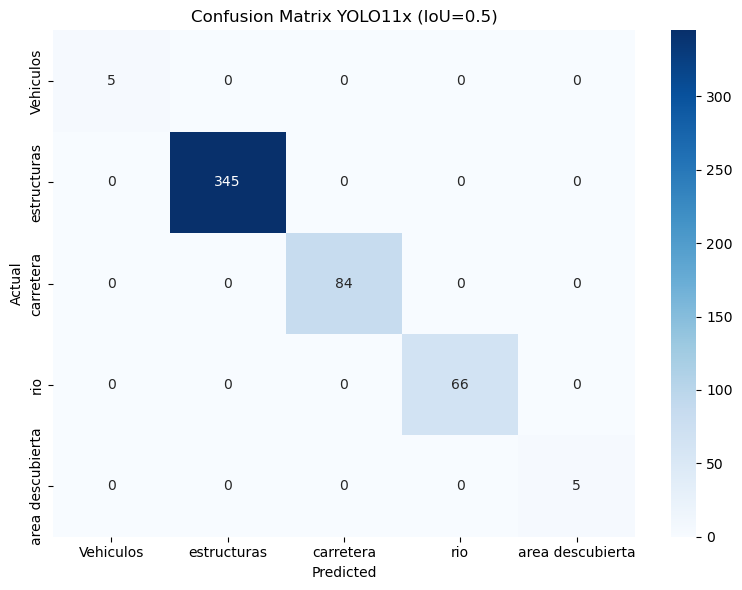

In [53]:
# Configuración
IMGS_DIR = "/Users/juank/Desktop/computer_vision/proyecto/Imagenes/test"
LABELS_DIR = "/Users/juank/Desktop/computer_vision/proyecto/Etiquetas/test"
URL = "http://localhost:8000/predict?model_type=yolo"
CLASS_NAMES = ['Vehiculos', 'estructuras', 'carretera', 'rio', 'area descubierta']
NUM_CLASSES = len(CLASS_NAMES)
IOU_THRESHOLDS = [0.5, 0.75]  # para mAP@0.5 y @0.5:0.95

# Función para leer etiquetas reales en formato YOLO
def load_yolo_labels(txt_path, img_w, img_h):
    labels = []
    with open(txt_path) as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            xmin = int((x - w / 2) * img_w)
            ymin = int((y - h / 2) * img_h)
            xmax = int((x + w / 2) * img_w)
            ymax = int((y + h / 2) * img_h)
            labels.append([int(cls), xmin, ymin, xmax, ymax])
    return labels

# Almacenar predicciones y etiquetas
all_preds = []
all_gts = []

print("Evaluando inferencia en todas las imágenes...")

for img_name in tqdm(os.listdir(IMGS_DIR)):
    if not img_name.endswith(('.jpg', '.png')):
        continue

    img_path = os.path.join(IMGS_DIR, img_name)
    label_path = os.path.join(LABELS_DIR, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    # Tamaño de imagen
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Realizar inferencia vía API
    with open(img_path, "rb") as f:
        files = {"file": (img_path, f, "image/jpeg")}
        response = requests.post(URL, files=files)
        detections = response.json()["detections"]

    # Convertir predicciones
    preds = []
    for d in detections:
        label = int(d["label"])
        score = float(d["score"])
        xmin, ymin, xmax, ymax = map(int, d["box"])
        preds.append([label, score, xmin, ymin, xmax, ymax])

    # Convertir etiquetas reales
    gts = load_yolo_labels(label_path, w, h)

    all_preds.append(preds)
    all_gts.append(gts)

# =============================
# Evaluación (mAP y métricas)
# =============================
def compute_metrics(preds_all, gts_all, iou_thresh=0.5):
    TP, FP, FN = 0, 0, 0
    y_true, y_pred = [], []

    confusion = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)

    for preds, gts in zip(preds_all, gts_all):
        matched = set()
        gt_boxes = [gt[1:] for gt in gts]
        gt_classes = [gt[0] for gt in gts]

        for pred in preds:
            pred_cls, score, *box = pred
            box = np.array(box).reshape(1, 4)

            if len(gt_boxes) > 0:
                ious = box_iou(torch.tensor(box), torch.tensor(gt_boxes)).numpy()[0]
                best_iou_idx = np.argmax(ious)
                best_iou = ious[best_iou_idx]

                if best_iou >= iou_thresh and best_iou_idx not in matched:
                    true_cls = gt_classes[best_iou_idx]
                    confusion[true_cls, pred_cls] += 1
                    y_true.append(true_cls)
                    y_pred.append(pred_cls)
                    matched.add(best_iou_idx)
                    TP += 1
                else:
                    FP += 1
            else:
                FP += 1

        FN += len(gt_boxes) - len(matched)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    return precision, recall, confusion

# Calcular métricas
import torch
precision, recall, cm = compute_metrics(all_preds, all_gts, iou_thresh=0.5)

# Mostrar resultados
print(f"\n📊 Precision: {precision:.3f}")
print(f"📊 Recall:    {recall:.3f}")

# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix YOLO11x (IoU=0.5)")
plt.tight_layout()
plt.show()

In [54]:
resultados = compute_map(all_preds, all_gts, num_classes=5)
resultados

{'mAP@0.5': 0.3767876675372319,
 'mAP@0.5:0.95': 0.03767876675372319,
 'AP_per_class@0.5': [0.4166665486111376,
  0.49586649094892676,
  0.20169119153660361,
  0.6190875834478535,
  0.15062652314163805],
 'iou_thresholds': [0.5,
  0.55,
  0.6000000000000001,
  0.6500000000000001,
  0.7000000000000002,
  0.7500000000000002,
  0.8000000000000003,
  0.8500000000000003,
  0.9000000000000004,
  0.9500000000000004]}

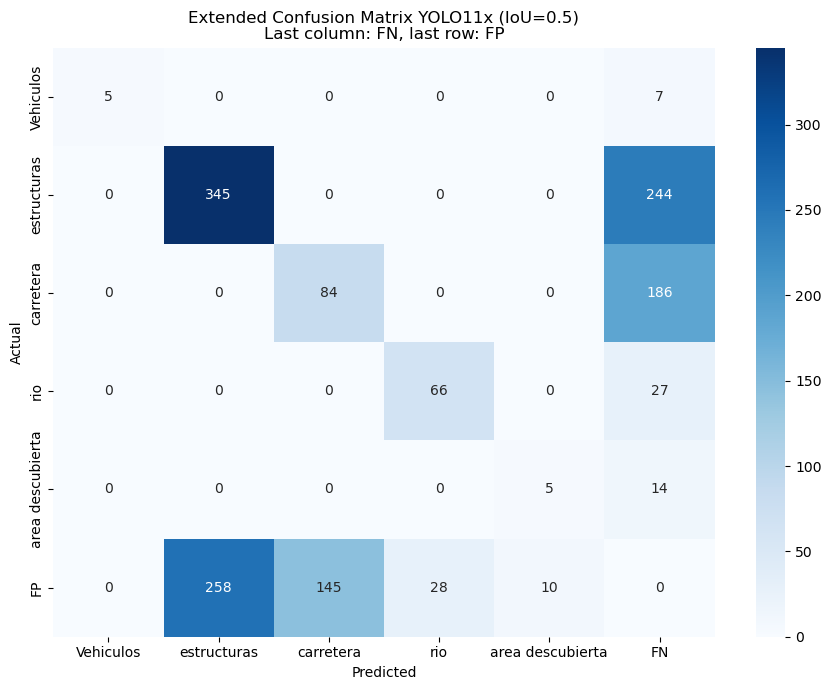

In [55]:
import numpy as np

NUM_CLASSES = len(CLASS_NAMES)
cm = np.zeros((NUM_CLASSES+1, NUM_CLASSES+1), dtype=int)  # +1 para FN y FP

for preds, gts in zip(all_preds, all_gts):
    matched = set()
    gt_boxes = [gt[1:] for gt in gts]
    gt_classes = [gt[0] for gt in gts]

    # Match detections to ground truth
    for pred in preds:
        pred_cls, score, *box = pred
        box = np.array(box).reshape(1, 4)

        if len(gt_boxes) > 0:
            ious = box_iou(torch.tensor(box), torch.tensor(gt_boxes)).numpy()[0]
            best_iou_idx = np.argmax(ious)
            best_iou = ious[best_iou_idx]

            if best_iou >= 0.5 and best_iou_idx not in matched:
                true_cls = gt_classes[best_iou_idx]
                cm[true_cls, pred_cls] += 1  # Acierto
                matched.add(best_iou_idx)
            else:
                cm[NUM_CLASSES, pred_cls] += 1  # FP (detectó algo que no corresponde)
        else:
            cm[NUM_CLASSES, pred_cls] += 1  # FP

    # Falsos negativos: ground truths no detectados
    for i, gt in enumerate(gts):
        if i not in matched:
            true_cls = gt[0]
            cm[true_cls, NUM_CLASSES] += 1  # FN (no detectó objeto real)

# Etiquetas para matriz extendida
xticks = CLASS_NAMES + ['FN']
yticks = CLASS_NAMES + ['FP']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=xticks, yticklabels=yticks, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Extended Confusion Matrix YOLO11x (IoU=0.5)\nLast column: FN, last row: FP")
plt.tight_layout()
plt.show()